# Iterated Prisoner's Dilemma On A Network

## Imports and Config

In [242]:
import math
import random
import logging
import numpy as np
import pandas as pd
import networkx as nx
from functools import partial
from dataclasses import dataclass
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
from matplotlib.animation import FuncAnimation

## Matrices

In [243]:
payoff_matrices = {
    "Default": {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 4),
        ("D", "C"): (4, 0),
        ("D", "D"): (1, 1),
    },
    "Canonical": {
        ("C", "C"): (-1, -1),
        ("C", "D"): (-3, 0),
        ("D", "C"): (0, -3),
        ("D", "D"): (-2, -2),
    },
    "Snowdrift": {
        ("C", "C"): (500, 500),
        ("C", "D"): (200, 800),
        ("D", "C"): (800, 200),
        ("D", "D"): (0, 0),
    },
}

## Classes

### Strategy

In [244]:
class ActionStrategy:
    """Strategy that always plays its current action, randomly initialized."""

    def __init__(self, rng):
        self.rng = rng
        self.action = "C" if self.rng.random() < 0.5 else "D"

    def decide(self, agent_history):
        return self.action

    def set_action(self, action):
        self.action = action

In [245]:
class ImitationStrategy(ActionStrategy):
    """Imitate the action with the highest mean payoff in interactions."""

    def decide(self, agent_history):
        totals = {"C": 0.0, "D": 0.0}
        counts = {"C": 0, "D": 0}
        for interactions in agent_history.values():
            for inter in interactions:
                counts[inter.own_action] += 1
                counts[inter.neighbor_action] += 1
                totals[inter.own_action] += inter.own_reward
                totals[inter.neighbor_action] += inter.neighbor_reward

        mean_C = totals["C"] / counts["C"] if counts["C"] else 0
        mean_D = totals["D"] / counts["D"] if counts["D"] else 0

        if mean_C > mean_D:
            self.action = "C"
        elif mean_D > mean_C:
            self.action = "D"
        else:  # in case of a tie, continue with the existing strategy
            pass

        return self.action

In [246]:
class FermiStrategy(ActionStrategy):
    """
    Endogenous Fermi algorithm (pairwise).
    """

    def __init__(self, rng, temperature=0.1):
        super().__init__(rng)
        self.K = temperature

    def decide(self, agent_history):
        # if no neighbours yet, keep current action
        if not agent_history:
            return self.action

        # pick one random neighbour we've interacted with
        neighbour_id = self.rng.choice(list(agent_history.keys()))
        interactions = agent_history.get(neighbour_id, [])
        if not interactions:
            return self.action

        # estimate payoffs from history with that neighbour
        own_rewards = [i.own_reward for i in interactions]
        neigh_rewards = [i.neighbor_reward for i in interactions]

        payoff_self = float(np.mean(own_rewards)) if own_rewards else 0.0
        payoff_neigh = float(np.mean(neigh_rewards)) if neigh_rewards else 0.0

        delta = payoff_neigh - payoff_self

        # Fermi probability
        if self.K == 0:
            p_switch = 1.0 if delta > 0 else 0.0
        else:
            exponent = -delta / self.K
            exponent = max(min(exponent, 700), -700)  # avoid overflow
            p_switch = 1.0 / (1.0 + math.exp(exponent))

        # switch action to neighbour's most recently observed action
        if self.rng.random() < p_switch:
            self.action = interactions[-1].neighbor_action

        return self.action

In [247]:
class ReinforcementLearningStrategy(ActionStrategy):
    """
    Q-learning strategy with epsilon-greedy action selection.
    """

    def __init__(self, rng, learning_rate=0.1, epsilon=0.1, initial_q=0.0):
        super().__init__(rng)
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.q = {"C": float(initial_q), "D": float(initial_q)}
        self._last_action = None
        self._last_reward = 0.0

    def decide(self, agent_history):
        # observe most recent reward from any interaction (if exists)
        last = None
        for interactions in agent_history.values():
            if interactions:
                cand = interactions[-1]
                if last is None:
                    last = cand
        if last is not None:
            self._last_reward = last.own_reward

        # update Q for the action we previously played
        if self._last_action is not None:
            a = self._last_action
            self.q[a] = self.q[a] + self.alpha * (self._last_reward - self.q[a])

        # choose next action (epsilon-greedy)
        if self.rng.random() < self.epsilon:
            action = "C" if self.rng.random() < 0.5 else "D"
        else:
            if self.q["C"] > self.q["D"]:
                action = "C"
            elif self.q["D"] > self.q["C"]:
                action = "D"
            else:
                action = "C" if self.rng.random() < 0.5 else "D"

        self.action = action
        self._last_action = action
        return self.action

In [248]:
class TitForTatStrategy(ActionStrategy):
    """
    Use the most common neighbor action from last round.
    """

    def decide(self, agent_history):
        if not agent_history:
            return self.action

        # collect the most recent action from each neighbor
        recent_actions = []
        for interactions in agent_history.values():
            if interactions:
                recent_actions.append(interactions[-1].neighbor_action)

        if not recent_actions:
            # no interactions recorded, default to cooperate
            self.action = "C"
        else:
            # copy the most common action (ties go to C)
            c_count = recent_actions.count("C")
            d_count = recent_actions.count("D")
            if d_count > c_count:
                self.action = "D"
            else:
                self.action = "C"

        return self.action

### Agent

In [249]:
class Agent:
    """Minimal agent holding a strategy, payoff, and history."""

    @dataclass
    class Interaction:
        own_action: str
        own_reward: float
        neighbor_action: str
        neighbor_reward: float

    def __init__(self, agent_id, strategy, history_window=5, store_history=True):
        self.id = agent_id
        self.strategy = strategy
        self.history = {}
        self.payoff = 0.0
        self.history_window = history_window
        self.store_history = store_history

    def choose_action(self):
        return self.strategy.decide(self.history)

    def record_interaction(
        self, neighbor_id, own_action, neighbor_action, own_reward, neighbor_reward
    ):
        self.payoff += own_reward
        if not self.store_history:
            return
        lst = self.history.setdefault(neighbor_id, [])
        lst.append(
            self.Interaction(own_action, own_reward, neighbor_action, neighbor_reward)
        )
        if len(lst) > self.history_window:
            del lst[: -self.history_window]

### Network

In [250]:
class Network:
    """NetworkX graph wrapper."""

    def generate_graph(self, kind, n, seed=None, **kwargs):
        """Generate a networkx graph by name."""
        if kind == "grid":
            side_length = int(math.sqrt(n))
            graph = nx.convert_node_labels_to_integers(
                nx.grid_2d_graph(side_length, side_length)
            )

        elif kind == "stochastic_block":
            sizes = kwargs.pop("sizes")
            p = kwargs.pop("p")
            graph = nx.stochastic_block_model(sizes, p, seed=seed, **kwargs)

        else:
            generators = {
                "erdos_renyi": nx.erdos_renyi_graph,
                "watts_strogatz": nx.watts_strogatz_graph,
                "barabasi_albert": nx.barabasi_albert_graph,
            }
            graph = generators[kind](n, seed=seed, **kwargs)

        self.kind = kind
        self.graph = graph
        self.seed = seed

    def neighbour(self, agent_id):
        """Return neighbour agent IDs."""
        if self.graph:
            return list(self.graph.neighbors(agent_id))
        else:
            raise NotImplementedError

In [251]:
class NetworkSimulation(Network):
    """
    Base class for running evolutionary games on any NetworkX graph.
    """

    def __init__(
        self,
        kind="grid",
        n=400,
        seed=42,
        rounds=100,
        strategy=ActionStrategy,
        strategy_kwargs=None,
        payoff_matrix=payoff_matrices["Default"],
        rng=None,
        history_window=20,
        store_history=True,
        store_snapshots=True,
        **graph_kwargs,
    ):
        self.strategy = strategy
        self.strategy_kwargs = strategy_kwargs or {}
        self.rounds = rounds
        self.payoff_matrix = payoff_matrix
        self.rng = rng if rng is not None else np.random.default_rng(seed)
        self.history_window = history_window
        self.store_history = store_history
        self.store_snapshots = store_snapshots
        self.generate_graph(kind=kind, n=n, seed=seed, **graph_kwargs)
        self.edge_list = list(self.graph.edges())
        self._neighbor_index_cache = None
        self.agents = {}
        self.snapshots = []
        self._initialize_agents()

    def _initialize_agents(self):
        for agent_id in self.graph.nodes:
            strat = self.strategy(self.rng, **self.strategy_kwargs)
            self.agents[agent_id] = Agent(
                agent_id,
                strat,
                history_window=self.history_window,
                store_history=self.store_history,
            )

    def _neighbor_indices(self):
        """Cache node and neighbor indices for fast neighbor stats."""
        if self._neighbor_index_cache is not None:
            return self._neighbor_index_cache

        nodes = list(self.graph.nodes())
        index = {node: i for i, node in enumerate(nodes)}
        neigh_idx = []
        for node in nodes:
            neigh = list(self.graph.neighbors(node))
            if not neigh:
                continue
            neigh_idx.append((index[node], [index[n] for n in neigh]))

        self._neighbor_index_cache = neigh_idx
        return neigh_idx

    def _reset_payoffs(self):
        for agent in self.agents.values():
            agent.payoff = 0.0

    # fast inner loop: precompute lookups and actions once
    def _play_round(self):
        agents = self.agents
        payoff_matrix = self.payoff_matrix
        edge_list = self.edge_list

        for agent in agents.values():
            agent.payoff = 0.0

        actions = {node: agents[node].choose_action() for node in agents}
        for node_a, node_b in edge_list:
            action_a = actions[node_a]
            action_b = actions[node_b]
            payoff_a, payoff_b = payoff_matrix.get((action_a, action_b), (0, 0))
            agents[node_a].record_interaction(
                node_b, action_a, action_b, payoff_a, payoff_b
            )
            agents[node_b].record_interaction(
                node_a, action_b, action_a, payoff_b, payoff_a
            )

    def _get_state(self):
        return {
            node_id: (1 if agent.strategy.action == "D" else 0)
            for node_id, agent in self.agents.items()
        }

    def state01_array(self):
        """Return state array in graph node order: 0=C, 1=D."""
        return np.fromiter(
            (
                1 if self.agents[i].strategy.action == "D" else 0
                for i in self.graph.nodes()
            ),
            dtype=np.uint8,
            count=self.graph.number_of_nodes(),
        )

    def encode_state(self):  # for speed
        arr = self.state01_array()
        return np.packbits(arr, bitorder="little").tobytes()

    def decode_state(self, packed):
        n = self.graph.number_of_nodes()
        bits = np.unpackbits(np.frombuffer(packed, dtype=np.uint8), bitorder="little")
        return bits[:n].astype(np.uint8)

    # Detect fixed points or cycles by hashing compact states
    def run_until_attractor(
        self,
        max_steps=2000,
        check_every=1,
        store_cycle_states=True,
    ):
        seen = {}
        cache = []
        for t in range(max_steps + 1):
            key = None
            if t % check_every == 0:
                key = self.encode_state()
                if key in seen:
                    t0 = seen[key]
                    period = t - t0
                    attractor = "fixed" if period == 1 else "cycle"
                    cycle_states = cache[t0:t] if store_cycle_states else None
                    return {
                        "t_end": t,
                        "t_cycle_start": t0,
                        "period": period,
                        "attractor": attractor,
                        "cycle_states": cycle_states,
                    }
                seen[key] = t

            if store_cycle_states:
                if key is None:
                    key = self.encode_state()
                cache.append(key)

            self.step()

        return {
            "t_end": max_steps,
            "t_cycle_start": None,
            "period": None,
            "attractor": "unknown",
            "cycle_states": None,
        }

    def cooperation_assortment(self, state01=None):
        """Return long-run cooperation fraction and neighbor-assortment r."""
        if state01 is None:
            state01 = self.state01_array()
        coop01 = 1 - state01  # 1=C, 0=D for correlation

        xs = []
        neigh_means = []
        for node_i, neigh_is in self._neighbor_indices():
            xs.append(coop01[node_i])
            neigh_means.append(float(np.mean(coop01[neigh_is])))

        if len(xs) < 2:
            r = 0.0
        else:
            xs_arr = np.array(xs, dtype=float)
            neigh_arr = np.array(neigh_means, dtype=float)
            if np.std(xs_arr) == 0 or np.std(neigh_arr) == 0:
                r = 0.0
            else:
                r = float(np.corrcoef(xs_arr, neigh_arr)[0, 1])

        return {
            "coop_frac": float((coop01 == 1).mean()),
            "assortment_r": r,
        }

    def cooperation_neighbor_stats(self, state01=None):
        """Return covariance/correlation of agent vs neighbor cooperation."""
        if state01 is None:
            state01 = self.state01_array()
        coop01 = 1 - state01

        xs = []
        neigh_means = []
        for node_i, neigh_is in self._neighbor_indices():
            xs.append(coop01[node_i])
            neigh_means.append(float(np.mean(coop01[neigh_is])))

        if len(xs) < 2:
            return {"cov": 0.0, "corr": 0.0}

        xs_arr = np.array(xs, dtype=float)
        neigh_arr = np.array(neigh_means, dtype=float)
        cov = float(np.cov(xs_arr, neigh_arr, ddof=0)[0, 1])
        if np.std(xs_arr) == 0 or np.std(neigh_arr) == 0:
            corr = 0.0
        else:
            corr = float(np.corrcoef(xs_arr, neigh_arr)[0, 1])

        return {"cov": cov, "corr": corr}

    def cooperation_metrics(self, state01=None):
        """Return basic cooperator cluster metrics for the current state."""
        if state01 is None:
            state01 = self.state01_array()
        coop_nodes = [
            node for node, val in zip(self.graph.nodes(), state01) if val == 0
        ]
        if not coop_nodes:
            return {
                "coop_frac": 0.0,
                "n_coop_clusters": 0,
                "largest_coop_cluster": 0,
                "mean_coop_cluster_size": 0.0,
            }
        H = self.graph.subgraph(coop_nodes)
        comps = list(nx.connected_components(H))
        sizes = sorted([len(c) for c in comps], reverse=True)
        return {
            "coop_frac": float((state01 == 0).mean()),
            "n_coop_clusters": int(len(sizes)),
            "largest_coop_cluster": int(sizes[0]) if sizes else 0,
            "mean_coop_cluster_size": float(np.mean(sizes)) if sizes else 0.0,
        }

    def step(self):
        self._play_round()
        if self.store_snapshots:
            self.snapshots.append(self._get_state())

    def run(self):
        for _ in range(self.rounds):
            self.step()

## Helpers

In [252]:
def network_statistics(graph, include_path_metrics=True):
    """Compute graph-level controls/mediators."""
    if graph.number_of_nodes() == 0:
        return {
            "avg_clustering": 0.0,
            "transitivity": 0.0,
            "avg_shortest_path": np.nan,
            "approx_diameter": np.nan,
            "degree_cv": np.nan,
            "degree_assortativity": np.nan,
            "mean_degree": np.nan,
        }

    degrees = np.array([d for _, d in graph.degree()], dtype=float)
    degree_mean = float(degrees.mean()) if len(degrees) else 0.0
    degree_std = float(degrees.std()) if len(degrees) else 0.0
    degree_cv = degree_std / degree_mean if degree_mean > 0 else np.nan

    avg_path = np.nan
    approx_diam = np.nan
    if include_path_metrics and graph.number_of_edges() > 0:
        # Path-based stats on the giant component only.
        gc_nodes = max(nx.connected_components(graph), key=len)
        gc = graph.subgraph(gc_nodes)
        if gc.number_of_nodes() > 1:
            avg_path = nx.average_shortest_path_length(gc)
            approx_diam = nx.approximation.diameter(gc)

    return {
        "avg_clustering": float(nx.approximation.average_clustering(graph)),
        "transitivity": float(nx.transitivity(graph)),
        "avg_shortest_path": float(avg_path) if avg_path is not None else np.nan,
        "approx_diameter": float(approx_diam) if approx_diam is not None else np.nan,
        "degree_cv": float(degree_cv),
        "degree_assortativity": float(nx.degree_assortativity_coefficient(graph)),
        "mean_degree": float(degree_mean),
    }


def trailing_window_metrics(model, steps, window=100, include_cov_stats=False):
    """Average cooperation/assortment over the last window of steps."""
    coop_vals = []
    assort_vals = []
    cov_vals = []
    corr_vals = []
    largest_vals = []

    for t in range(steps):
        model.step()
        if t >= steps - window:
            state01 = model.state01_array()
            coop_vals.append(float((state01 == 0).mean()))
            assort_vals.append(model.cooperation_assortment(state01)["assortment_r"])
            if include_cov_stats:
                cov_stats = model.cooperation_neighbor_stats(state01)
                cov_vals.append(cov_stats["cov"])
                corr_vals.append(cov_stats["corr"])
            cmet = model.cooperation_metrics(state01)
            largest_vals.append(cmet["largest_coop_cluster"])

    return {
        "tail_mean_coop_frac": float(np.mean(coop_vals)) if coop_vals else np.nan,
        "tail_mean_assortment": float(np.mean(assort_vals)) if assort_vals else np.nan,
        "tail_mean_cov": float(np.mean(cov_vals)) if cov_vals else np.nan,
        "tail_mean_corr": float(np.mean(corr_vals)) if corr_vals else np.nan,
        "tail_mean_largest_cluster": (
            float(np.mean(largest_vals)) if largest_vals else np.nan
        ),
    }


def run_architecture_sweep(
    configs,
    n,
    payoff_matrix,
    strategy_class,
    strategy_kwargs,
    seeds,
    max_steps=400,
    tail_window=120,
    include_path_metrics=False,
    include_cov_stats=False,
):
    """Run the same game across multiple network architectures."""
    rows = []
    strategy_kwargs = strategy_kwargs or {}

    for cfg in configs:
        kind = cfg["kind"]
        graph_kwargs = cfg.get("graph_kwargs", {})
        label = cfg.get("label", kind)
        mean_k_cfg = cfg.get("mean_k")
        param_name = cfg.get("param_name")
        param_value = cfg.get("param_value")

        for seed in seeds:
            model = NetworkSimulation(
                kind=kind,
                n=n,
                seed=seed,
                rounds=max_steps,
                payoff_matrix=payoff_matrix,
                strategy=strategy_class,
                strategy_kwargs=strategy_kwargs,
                store_snapshots=False,
                **graph_kwargs,
            )

            row = {
                "label": label,
                "kind": kind,
                "seed": seed,
                "n": n,
                "mean_k": mean_k_cfg,
                "param_name": param_name,
                "param_value": param_value,
            }

            for k, v in graph_kwargs.items():
                if isinstance(v, (int, float, str)):
                    row[k] = v

            row.update(network_statistics(model.graph, include_path_metrics))
            row.update(
                trailing_window_metrics(
                    model,
                    steps=max_steps,
                    window=tail_window,
                    include_cov_stats=include_cov_stats,
                )
            )
            rows.append(row)

    return pd.DataFrame(rows)


def detect_transition(df, param_col, y_col="tail_mean_coop_frac"):
    """Return the parameter value with the largest mean jump in y_col."""
    means = df.groupby(param_col)[y_col].mean().sort_index()
    diffs = means.diff().abs().dropna()
    if diffs.empty:
        return None
    return float(diffs.idxmax())

## Visualization

In [253]:
def experiment(
    network_simulation,
    strategy_class,
    strategy_kwargs=None,
    steps=100,
    seed=42,
    interval=300,
    payoff_matrix=payoff_matrices["Default"],
    title="",
    kind="grid",
    n=400,
    is_grid=False,
    **graph_kwargs,
):
    """
    Produce animations showing the network state over time.
    """
    payoff_matrix = payoff_matrix
    strategy_kwargs = strategy_kwargs or {}
    simulation = network_simulation(
        kind=kind,
        n=n,
        seed=seed,
        rounds=steps,
        payoff_matrix=payoff_matrix,
        strategy=strategy_class,
        strategy_kwargs=strategy_kwargs,
        **graph_kwargs,
    )

    graph = simulation.graph
    n_nodes = graph.number_of_nodes()

    C_COOP, C_DEFECT = "#40B0A6", "#FFBE6A"
    cmap = ListedColormap([C_COOP, C_DEFECT])
    fig, (ax_sim, ax_stats) = plt.subplots(
        2, 1, figsize=(7, 8), gridspec_kw={"height_ratios": [4, 1]}
    )

    # -------------------------
    # Stats plot (C% and D%)
    # -------------------------
    xs, ys_c, ys_d = [], [], []

    (line_c,) = ax_stats.plot([], [], lw=2, label="C")
    (line_d,) = ax_stats.plot([], [], lw=2, label="D")

    ax_stats.set_xlim(0, steps)
    ax_stats.set_ylim(0, 100)
    ax_stats.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    ax_stats.set_ylabel("Population")
    ax_stats.grid(True, linestyle=":", alpha=0.4)
    ax_stats.legend(frameon=False, ncol=2, loc="upper right")

    # -------------------------
    # Simulation plot
    # -------------------------
    if is_grid:
        dim = int(math.isqrt(n_nodes))
        if dim * dim != n_nodes:
            raise ValueError(f"Grid mode needs square number of nodes, got {n_nodes}.")

        def state_as_grid():
            state = simulation._get_state()
            grid = [[0] * dim for _ in range(dim)]
            for node, val in state.items():
                grid[node // dim][node % dim] = val
            return grid

        sim_artist = ax_sim.imshow(state_as_grid(), cmap=cmap, vmin=0, vmax=1)
        ax_sim.set_xticks([])
        ax_sim.set_yticks([])

        def update_sim():
            sim_artist.set_data(state_as_grid())

    else:
        pos = nx.spring_layout(graph, seed=seed)
        nodelist = list(graph.nodes())
        nx.draw_networkx_edges(graph, pos, ax=ax_sim, alpha=0.3, edge_color="gray")
        state0 = simulation._get_state()
        sim_artist = nx.draw_networkx_nodes(
            graph,
            pos,
            nodelist=nodelist,
            node_color=[state0[i] for i in nodelist],
            cmap=cmap,
            vmin=0,
            vmax=1,
            node_size=80,
            edgecolors="gray",
            ax=ax_sim,
        )
        ax_sim.axis("off")

        def update_sim():
            state = simulation._get_state()
            sim_artist.set_array([state[i] for i in nodelist])

    # -------------------------
    # Animation update
    # -------------------------
    def update(frame):
        if frame > 0:
            simulation.step()

        ax_sim.set_title(f"{title} (Step {frame}/{steps})")

        update_sim()

        state = simulation._get_state()
        d = sum(state.values())
        c = n_nodes - d

        xs.append(frame)
        ys_c.append(100 * c / n_nodes)
        ys_d.append(100 * d / n_nodes)

        line_c.set_data(xs, ys_c)
        line_d.set_data(xs, ys_d)

        return sim_artist, line_c, line_d

    anim = FuncAnimation(
        fig,
        update,
        frames=steps + 1,
        interval=interval,
        blit=True,
        repeat=False,
    )
    return anim

In [254]:
if False:
    matrix_names = ["Snowdrift", "Default"]
    size = 20
    n = size * size

    runs = [
        ("Imitation", ImitationStrategy, {}),
        ("Tit-for-Tat", TitForTatStrategy, {}),
        (
            "Reinforcement Learning",
            ReinforcementLearningStrategy,
            {
                "learning_rate": 0.1,
                "epsilon": 0.1,
                "initial_q": 0.0,
            },
        ),
    ]

    graph_setups = [
        ("Grid", "grid", {}, True),
        ("Small-World", "watts_strogatz", {"k": 4, "p": 0.1}, False),
        ("Erdos-Renyi", "erdos_renyi", {"p": 0.1}, False),
    ]

    for matrix_name in matrix_names:
        matrix = payoff_matrices[matrix_name]

        for graph_label, kind, graph_kwargs, is_grid in graph_setups:
            for strat_label, strat_cls, strat_kwargs in runs:
                ani = experiment(
                    network_simulation=NetworkSimulation,
                    strategy_class=strat_cls,
                    strategy_kwargs=strat_kwargs,
                    steps=60,
                    seed=42,
                    interval=50,
                    payoff_matrix=matrix,
                    kind=kind,
                    n=n,
                    is_grid=is_grid,
                    title=f"{strat_label} on {matrix_name} ({graph_label})",
                    **graph_kwargs,
                )
                display(ani)

## Statistics

,tail_mean_coop_frac,tail_mean_assortment,tail_mean_cov,tail_mean_corr,tail_mean_largest_cluster_frac,avg_clustering,mean_degree
label,,,,,,,
Watts-Strogatz,0.024444,0.415103,0.007971,0.415103,0.015648,0.375000,4.000000
Erdos-Renyi,0.013056,0.255519,0.002288,0.255519,0.006759,0.044333,4.250000
Grid,0.007444,0.151071,0.002031,0.151071,0.004630,0.000000,3.600000
Barabasi-Albert,0.002130,0.082448,0.000683,0.082448,0.002130,0.123667,3.933333


/Users/tristanfarran/.default-py/lib/python3.13/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


,kind,param_name,param_value,percolates
0,barabasi_albert,m,2.000000,0.0
1,barabasi_albert,m,3.000000,0.0
2,barabasi_albert,m,4.000000,0.0
3,erdos_renyi,p,0.020000,0.0
4,erdos_renyi,p,0.033333,0.0
5,erdos_renyi,p,0.046667,0.0
6,erdos_renyi,p,0.060000,0.0
7,watts_strogatz,p,0.000000,0.0
8,watts_strogatz,p,0.050000,0.0
9,watts_strogatz,p,0.100000,0.0


Approx transition points (max jump in coop): {'barabasi_albert': 3.0, 'erdos_renyi': 0.03333333333333333, 'watts_strogatz': 0.05}


,tail_mean_coop_frac,avg_clustering,tail_mean_cov,tail_mean_corr
label,,,,
Watts-Strogatz,0.024444,0.375000,0.007971,0.415103
Erdos-Renyi,0.013056,0.044333,0.002288,0.255519


Cooperation vs neighbor covariance correlation: 0.9243521524955864


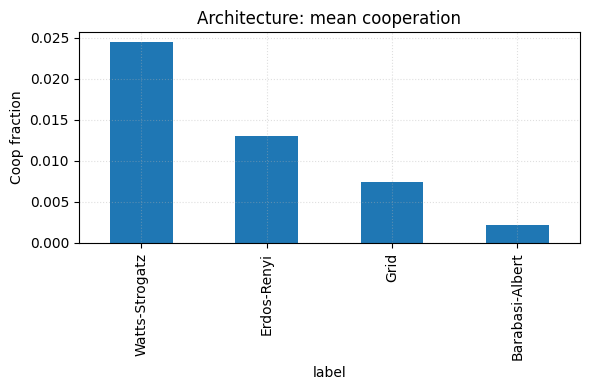

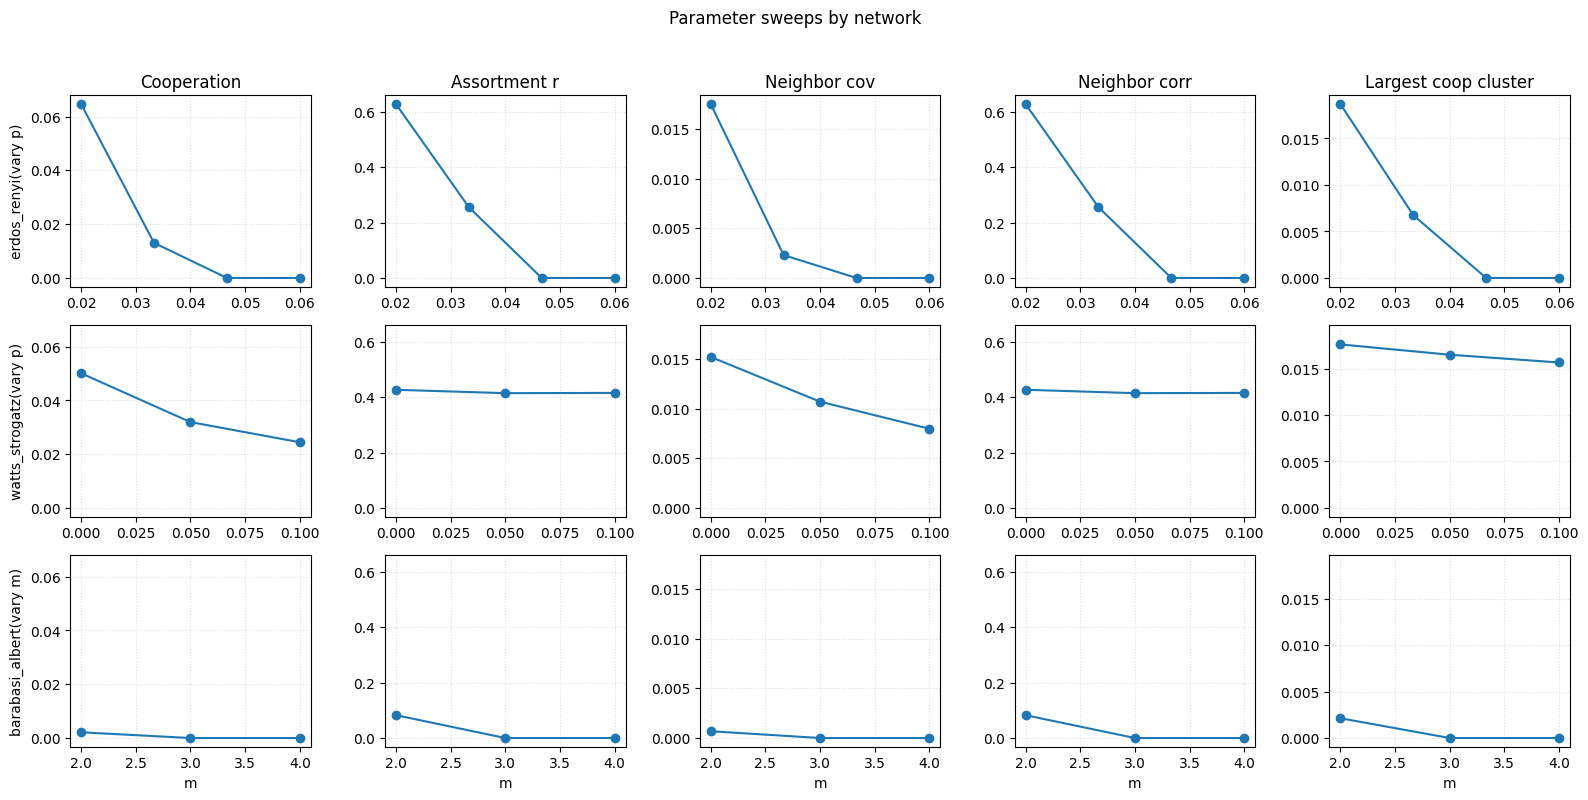

In [255]:
# Statistics

# -------------------------
# Configuration
# -------------------------
FAST_MODE = True
RUN_ARCH = True
RUN_PARAM_SWEEPS = True
RUN_PLOTS = True

SEEDS = list(range(6))
N = 200
STEPS = 300
TAIL = 120
MEAN_K = 4

if FAST_MODE:
    SEEDS = list(range(3))
    N = 120
    STEPS = 180
    TAIL = 60

STRATEGY = ImitationStrategy
PAYOFF = payoff_matrices["Default"]

# -------------------------
# Architecture comparison
# -------------------------
arch_df = None
if RUN_ARCH:
    arch_configs = [
        {"label": "Grid", "kind": "grid", "graph_kwargs": {}, "mean_k": 4},
        {
            "label": "Erdos-Renyi",
            "kind": "erdos_renyi",
            "graph_kwargs": {"p": MEAN_K / (N - 1)},
            "mean_k": MEAN_K,
        },
        {
            "label": "Watts-Strogatz",
            "kind": "watts_strogatz",
            "graph_kwargs": {"k": MEAN_K, "p": 0.1},
            "mean_k": MEAN_K,
        },
        {
            "label": "Barabasi-Albert",
            "kind": "barabasi_albert",
            "graph_kwargs": {"m": MEAN_K // 2},
            "mean_k": MEAN_K,
        },
    ]

    arch_df = run_architecture_sweep(
        arch_configs,
        n=N,
        payoff_matrix=PAYOFF,
        strategy_class=STRATEGY,
        strategy_kwargs=None,
        seeds=SEEDS,
        max_steps=STEPS,
        tail_window=TAIL,
        include_path_metrics=False,
        include_cov_stats=True,
    )
    arch_df["tail_mean_largest_cluster_frac"] = (
        arch_df["tail_mean_largest_cluster"] / arch_df["n"]
    )

    arch_summary = (
        arch_df.groupby("label")[
            [
                "tail_mean_coop_frac",
                "tail_mean_assortment",
                "tail_mean_cov",
                "tail_mean_corr",
                "tail_mean_largest_cluster_frac",
                "avg_clustering",
                "mean_degree",
            ]
        ]
        .mean()
        .sort_values("tail_mean_coop_frac", ascending=False)
    )

    display(arch_summary)

# -------------------------
# Parameter sweeps
# -------------------------
param_df = None
if RUN_PARAM_SWEEPS:
    ER_PS = np.linspace(0.01, 0.08, 6)
    WS_PS = [0.0, 0.02, 0.05, 0.1, 0.2]
    BA_MS = [2, 3, 4, 5]

    if FAST_MODE:
        ER_PS = np.linspace(0.02, 0.06, 4)
        WS_PS = [0.0, 0.05, 0.1]
        BA_MS = [2, 3, 4]

    sweep_configs = []
    for p in ER_PS:
        sweep_configs.append(
            {
                "label": "Erdos-Renyi",
                "kind": "erdos_renyi",
                "graph_kwargs": {"p": float(p)},
                "mean_k": float(p * (N - 1)),
                "param_name": "p",
                "param_value": float(p),
            }
        )
    for p in WS_PS:
        sweep_configs.append(
            {
                "label": "Watts-Strogatz",
                "kind": "watts_strogatz",
                "graph_kwargs": {"k": MEAN_K, "p": float(p)},
                "mean_k": MEAN_K,
                "param_name": "p",
                "param_value": float(p),
            }
        )
    for m in BA_MS:
        sweep_configs.append(
            {
                "label": "Barabasi-Albert",
                "kind": "barabasi_albert",
                "graph_kwargs": {"m": int(m)},
                "mean_k": float(2 * m),
                "param_name": "m",
                "param_value": float(m),
            }
        )

    param_df = run_architecture_sweep(
        sweep_configs,
        n=N,
        payoff_matrix=PAYOFF,
        strategy_class=STRATEGY,
        strategy_kwargs=None,
        seeds=SEEDS,
        max_steps=STEPS,
        tail_window=TAIL,
        include_path_metrics=False,
        include_cov_stats=True,
    )
    param_df["tail_mean_largest_cluster_frac"] = (
        param_df["tail_mean_largest_cluster"] / param_df["n"]
    )

    PERCO_THRESH = 0.4
    param_df["percolates"] = param_df["tail_mean_largest_cluster_frac"] >= PERCO_THRESH

    perco_summary = (
        param_df.groupby(["kind", "param_name", "param_value"])["percolates"]
        .mean()
        .reset_index()
    )

    display(perco_summary)

    transitions = {}
    for kind, sub in param_df.groupby("kind"):
        if sub["param_value"].notna().any():
            transitions[kind] = detect_transition(sub, "param_value")

    print("Approx transition points (max jump in coop):", transitions)

# -------------------------
# Clustering vs cooperation (mean degree held constant)
# -------------------------
if RUN_ARCH and arch_df is not None:
    cluster_compare = arch_df[arch_df["label"].isin(["Watts-Strogatz", "Erdos-Renyi"])]
    cluster_summary = (
        cluster_compare.groupby("label")[
            ["tail_mean_coop_frac", "avg_clustering", "tail_mean_cov", "tail_mean_corr"]
        ]
        .mean()
        .sort_values("avg_clustering", ascending=False)
    )

    display(cluster_summary)

# -------------------------
# Cooperation vs covariance check
# -------------------------
if RUN_ARCH and arch_df is not None and len(arch_df) > 1:
    corr = float(
        np.corrcoef(arch_df["tail_mean_coop_frac"], arch_df["tail_mean_cov"])[0, 1]
    )
    print("Cooperation vs neighbor covariance correlation:", corr)

# -------------------------
# Plots: architecture
# -------------------------
if RUN_PLOTS and RUN_ARCH and arch_df is not None:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    arch_summary["tail_mean_coop_frac"].plot(kind="bar", ax=ax)
    ax.set_title("Architecture: mean cooperation")
    ax.set_ylabel("Coop fraction")
    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()

# -------------------------
# Plots: per-network parameter panels (grid, shared y)
# -------------------------
if RUN_PLOTS and RUN_PARAM_SWEEPS and param_df is not None:
    metrics = [
        "tail_mean_coop_frac",
        "tail_mean_assortment",
        "tail_mean_cov",
        "tail_mean_corr",
        "tail_mean_largest_cluster_frac",
    ]
    metric_titles = {
        "tail_mean_coop_frac": "Cooperation",
        "tail_mean_assortment": "Assortment r",
        "tail_mean_cov": "Neighbor cov",
        "tail_mean_corr": "Neighbor corr",
        "tail_mean_largest_cluster_frac": "Largest coop cluster",
    }
    kinds = list(param_df["kind"].dropna().unique())
    if kinds:
        n_rows = len(kinds)
        n_cols = len(metrics)
        fig, axes = plt.subplots(
            n_rows,
            n_cols,
            figsize=(3.2 * n_cols, 2.6 * n_rows),
            sharey="col",
        )
        fig.suptitle("Parameter sweeps by network", y=1.02, fontsize=12)
        if n_rows == 1:
            axes = [axes]

        for i, kind in enumerate(kinds):
            sub = param_df[param_df["kind"] == kind]
            param_name = sub["param_name"].dropna().iloc[0]
            summary = sub.groupby("param_value")[metrics].mean().sort_index()

            for j, metric in enumerate(metrics):
                ax = axes[i][j] if n_rows > 1 else axes[0][j]
                ax.plot(summary.index, summary[metric], marker="o")
                if i == 0:
                    ax.set_title(metric_titles[metric])
                if i == n_rows - 1:
                    ax.set_xlabel(param_name)
                if j == 0:
                    ax.set_ylabel(f"{kind}(vary {param_name})")
                ax.grid(True, linestyle=":", alpha=0.4)

        plt.tight_layout()